In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    Flatten,
    concatenate,
    Dropout,
    Reshape,
    Multiply,
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define the path to your dataset
dataset_path = '/kaggle/input/muffin-vs-chihuahua-image-classification/'
desired_width = 120
desired_height = 120
# Define a function to load and preprocess images
def load_and_preprocess_images(folder_path):
    images = []
    labels = []
    # Define the desired width and height for the images
    desired_width = 120
    desired_height = 120

    # Loop through the class folders
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)

        # Loop through the images in each class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read the image in RGB format
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Append the preprocessed image to the list
            images.append(image)

            # Append the corresponding label (class name)
            labels.append(class_name)

    # Ensure all images have the same shape
    images = [cv2.resize(image, (desired_width, desired_height)) for image in images]

    return np.array(images), np.array(labels)


# Define paths for the train and test sets
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# Load and preprocess the train and test images
train_images, train_labels = load_and_preprocess_images(train_path)
test_images, test_labels = load_and_preprocess_images(test_path)

class_to_int = {'muffin': 0, 'chihuahua': 1}  # Add more classes as needed
num_classes=2
# Use the mapping to convert class labels to integers
train_labels_int = [class_to_int[label] for label in train_labels]
test_labels_int = [class_to_int[label] for label in test_labels]

# One-hot encode the integer labels
train_labels_one_hot = to_categorical(train_labels_int, num_classes)
test_labels_one_hot = to_categorical(test_labels_int, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         8

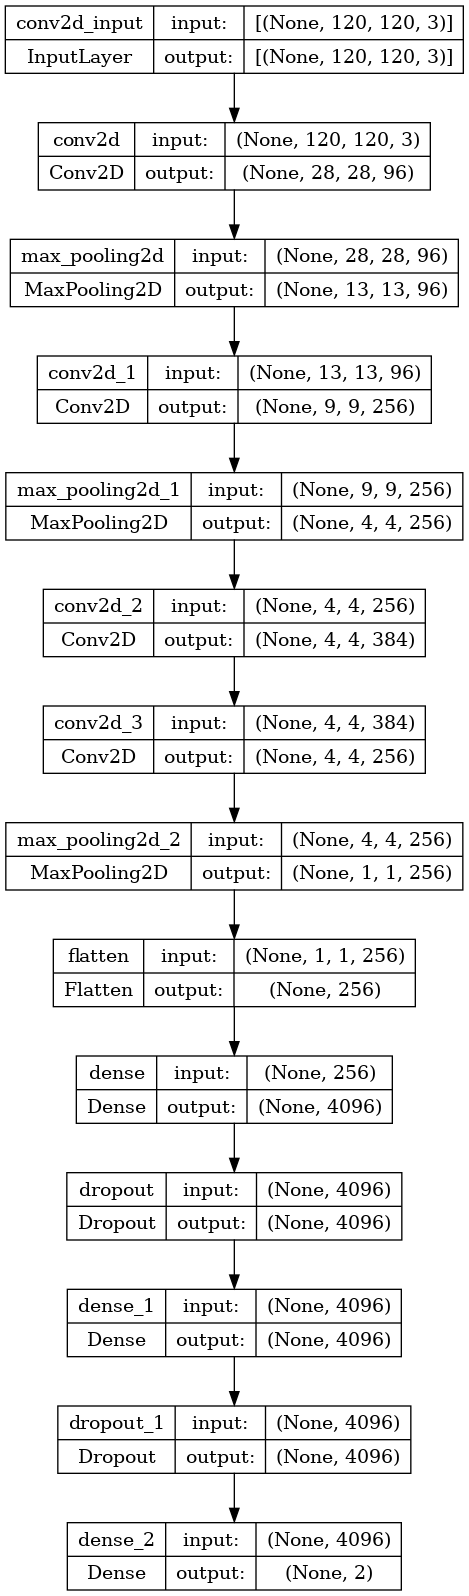

In [3]:
# The AlexNet model
AlexNet = Sequential([
    # Layer 1
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(desired_width, desired_height, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Layer 2
    Conv2D(256, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Layer 3
    Conv2D(384, (3, 3), activation='relu', padding='same'),

    
    # Layer 5
    Conv2D(256, (3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Flatten the output
    Flatten(),
    
    # Fully connected layers
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
AlexNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print model summary
AlexNet.summary() 
# Visualize the architecture and save it to a file
plot_model(AlexNet, to_file='alexnet_architecture.png', show_shapes=True, show_layer_names=True)

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 120, 120, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 120, 120, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

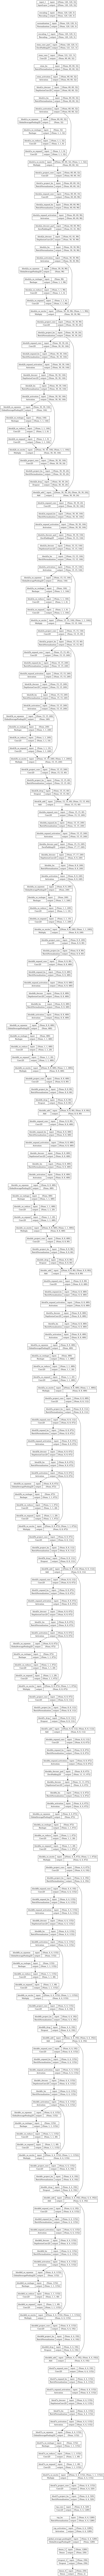

In [4]:
# The EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(desired_width, desired_height, 3))

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

Efficient_NetB0 = Model(inputs=base_model.input, outputs=output)

# Compile the model
Efficient_NetB0.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
Efficient_NetB0.summary() 
plot_model(Efficient_NetB0, to_file='Efficient_NetB0.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 116, 116, 6)       456       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 16)        2416      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 11664)             0         
                                                                 
 dense_5 (Dense)             (None, 120)              

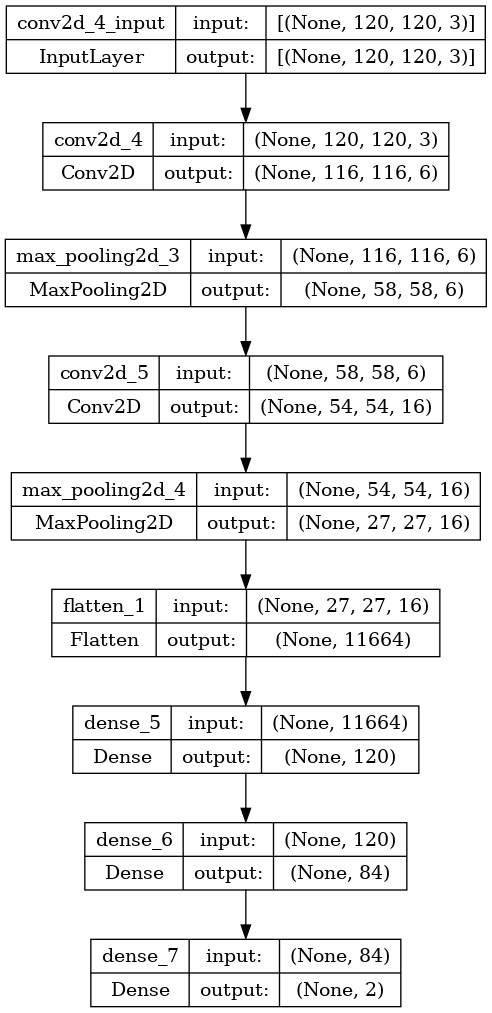

In [5]:
# The Sequential model
Sequential_CNN = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(desired_width, desired_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
Sequential_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model
Sequential_CNN.summary() 

# Plot the model's structure and save it as an image
plot_model(Sequential_CNN, to_file='Sequential_CNN.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 120, 120, 64)      0         
                                                                 
 se_block (SEBlock)          (None, 120, 120, 64)      580       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)      

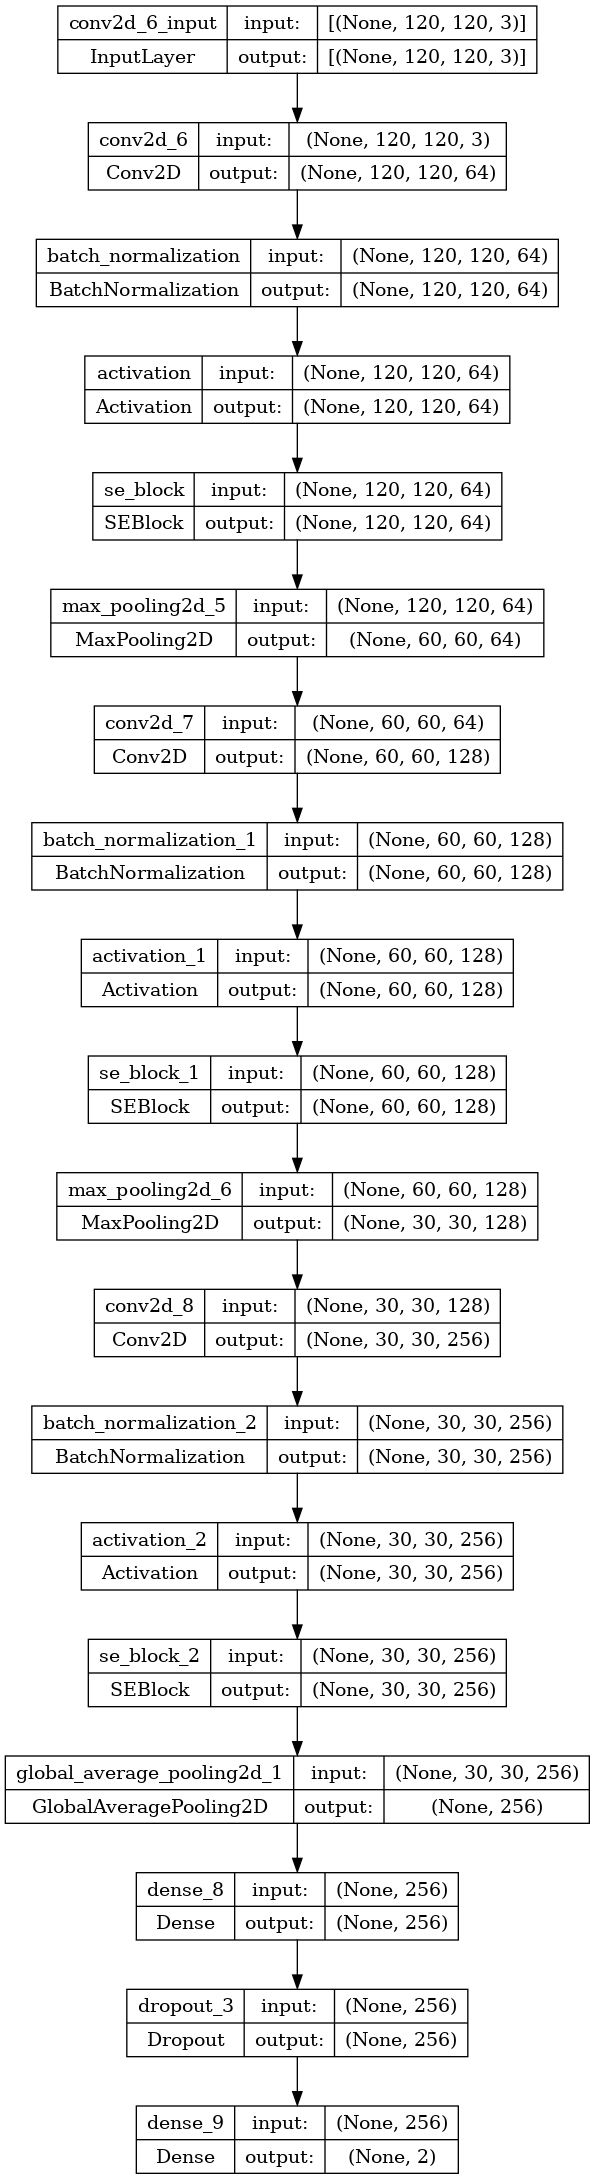

In [6]:
# Input tensor
input_tensor = Input(shape=(desired_width, desired_height, 3))

# The custom SE-Net-like block as a layer
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        num_channels = input_shape[-1]
        self.squeeze = GlobalAveragePooling2D()
        self.excitation1 = Dense(num_channels // self.ratio, activation='relu')
        self.excitation2 = Dense(num_channels, activation='sigmoid')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = Reshape((1, 1, -1))(x)
        x = self.excitation1(x)
        x = self.excitation2(x)
        return Multiply()([inputs, x])

SE_NET = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(desired_width, desired_height, 3)),
    BatchNormalization(),
    Activation('relu'),

    # Apply the custom SE-Net-like block after the first convolutional layer
    SEBlock(),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Apply the custom SE-Net-like block after the second convolutional layer
    SEBlock(),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Apply the custom SE-Net-like block after the third convolutional layer
    SEBlock(),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),

    Dropout(0.5),

    Dense(2, activation='softmax')
])

# Compile the model
SE_NET.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model
SE_NET.summary() 

# Plot the model's structure and save it as an image
plot_model(SE_NET, to_file='SE_NET.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 120, 120, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 120, 120, 64)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 120, 120, 64)      36928     
                                                                 
 batch_normalization_4 (Batc  (None, 120, 120, 64)     256       
 hNormalization)                                           

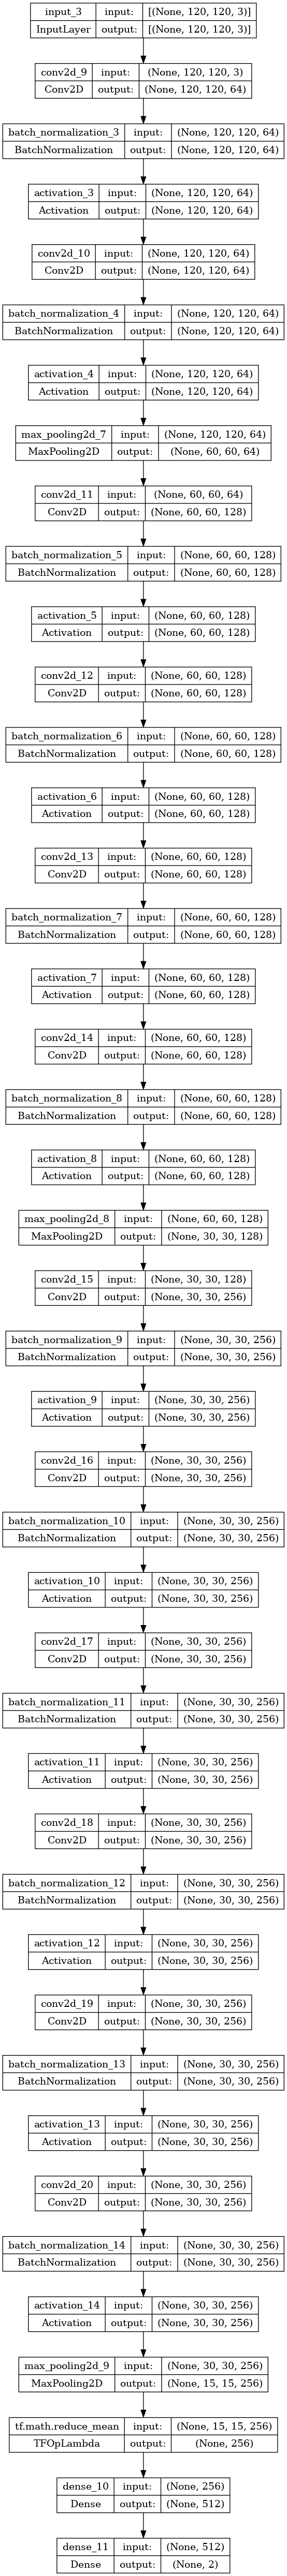

In [7]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def simplified_poly_net(input_shape, num_classes):
    input_layer = Input(shape=(desired_width, desired_height, 3))
    x = input_layer

    # Convolution Blocks
    for filters, repetitions in [(64, 2), (128, 4), (256, 6)]:
        for _ in range(repetitions):
            x = Conv2D(filters, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling Layer
    x = tf.reduce_mean(x, axis=[1, 2])  # Global average pooling

    # Fully Connected Layers
    x = Dense(512, activation='relu')(x)

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Example usage:
input_shape = (desired_width, desired_height, 3)  # Replace with your input shape
num_classes = 2  # Replace with the number of classes in your task

PolyNet = simplified_poly_net(input_shape, num_classes)

# Compile the model
PolyNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

PolyNet.summary()

# Plot the model's structure and save it as an image
plot_model(PolyNet, to_file='PolyNet.png', show_shapes=True, show_layer_names=True)


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def cv_5(model, X, y, epochs, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    all_confusion_matrices = []  # To store confusion matrices for each fold

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        history = model.fit(
            tf.constant(X_train),
            y_train,  
            validation_data=(tf.constant(X_test), y_test),
            batch_size=128,
            epochs=epochs,
            verbose=1
        )

        # Predict on the test data
        y_pred = model.predict(tf.constant(X_test))

        # Calculate zero-one loss
        zero_one = 1 - zero_one_loss(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        accuracies.append(zero_one)

        # Calculate confusion matrix
        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        all_confusion_matrices.append(cm)

    # Calculate average metrics over all folds
    avg_accuracy = np.mean(accuracies)

    # Calculate the average confusion matrix
    avg_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
    avg_metrics = {"Average Accuracy": avg_accuracy, "Average Confusion Matrix": avg_confusion_matrix}

    # Plot the average confusion matrix
    sns.heatmap(avg_metrics["Average Confusion Matrix"], annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Average Confusion Matrix")
    plt.show()
    
    return {"Average Accuracy": avg_accuracy, "Average Confusion Matrix": avg_confusion_matrix}


Epoch 1/5
30/30 [==============================] - 11s 373ms/step - loss: 0.1166 - accuracy: 0.9551 - val_loss: 0.2165 - val_accuracy: 0.9271
Epoch 2/5
30/30 [==============================] - 11s 353ms/step - loss: 0.1174 - accuracy: 0.9535 - val_loss: 0.8667 - val_accuracy: 0.7973
Epoch 3/5
30/30 [==============================] - 11s 354ms/step - loss: 0.1148 - accuracy: 0.9572 - val_loss: 0.3735 - val_accuracy: 0.8933
Epoch 4/5
30/30 [==============================] - 11s 371ms/step - loss: 0.1087 - accuracy: 0.9604 - val_loss: 0.1739 - val_accuracy: 0.9388
Epoch 5/5
30/30 [==============================] - 1s 32ms/step
Epoch 1/5
30/30 [==============================] - 11s 371ms/step - loss: 0.0881 - accuracy: 0.9654 - val_loss: 0.4310 - val_accuracy: 0.8955
Epoch 2/5
30/30 [==============================] - 11s 370ms/step - loss: 0.1060 - accuracy: 0.9583 - val_loss: 1.3726 - val_accuracy: 0.8353
Epoch 3/5
30/30 [==============================] - 11s 371ms/step - loss: 0.0828 - a

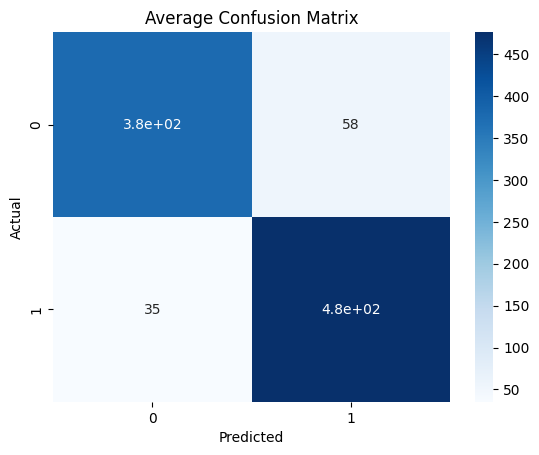

{'Average Accuracy': 0.9017406698799592,
 'Average Confusion Matrix': array([[377.2,  57.6],
        [ 35.4, 476.4]])}

In [18]:
cv_5(PolyNet, train_images, train_labels_one_hot, epochs=5)

Epoch 1/5
30/30 [==============================] - 10s 141ms/step - loss: 0.4651 - accuracy: 0.7892 - val_loss: 3.7205 - val_accuracy: 0.5480
Epoch 2/5
30/30 [==============================] - 4s 132ms/step - loss: 0.3430 - accuracy: 0.8645 - val_loss: 3.7229 - val_accuracy: 0.5480
Epoch 3/5
30/30 [==============================] - 4s 126ms/step - loss: 0.3114 - accuracy: 0.8774 - val_loss: 1.9892 - val_accuracy: 0.5502
Epoch 4/5
30/30 [==============================] - 4s 129ms/step - loss: 0.2872 - accuracy: 0.8833 - val_loss: 1.5332 - val_accuracy: 0.5618
Epoch 5/5
30/30 [==============================] - 1s 12ms/step
Epoch 1/5
30/30 [==============================] - 4s 128ms/step - loss: 0.2754 - accuracy: 0.8880 - val_loss: 0.8792 - val_accuracy: 0.6674
Epoch 2/5
30/30 [==============================] - 4s 126ms/step - loss: 0.2480 - accuracy: 0.8980 - val_loss: 0.3725 - val_accuracy: 0.8543
Epoch 3/5
30/30 [==============================] - 4s 128ms/step - loss: 0.2192 - accurac

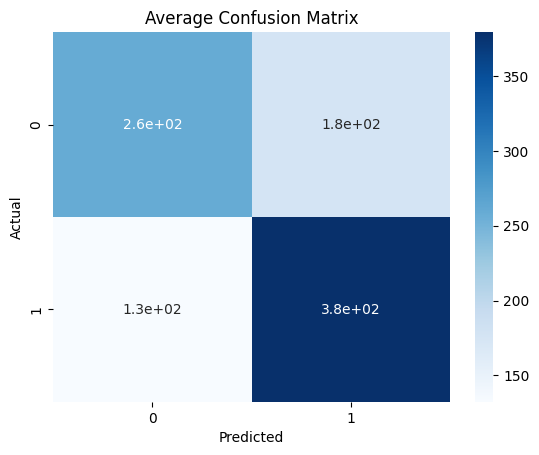

{'Average Accuracy': 0.6741924537484568,
 'Average Confusion Matrix': array([[258.8, 176. ],
        [132.4, 379.4]])}

In [14]:
cv_5(SE_NET, train_images, train_labels_one_hot, epochs=5)

Epoch 1/5
30/30 [==============================] - 4s 32ms/step - loss: 72.7972 - accuracy: 0.5217 - val_loss: 0.7867 - val_accuracy: 0.5597
Epoch 2/5
30/30 [==============================] - 0s 16ms/step - loss: 0.6507 - accuracy: 0.6476 - val_loss: 0.6896 - val_accuracy: 0.5966
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 0.4594 - accuracy: 0.8146 - val_loss: 0.7916 - val_accuracy: 0.6378
Epoch 4/5
30/30 [==============================] - 0s 16ms/step - loss: 0.2340 - accuracy: 0.9120 - val_loss: 0.9357 - val_accuracy: 0.6346
Epoch 5/5
30/30 [==============================] - 0s 3ms/step
Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 0.3082 - accuracy: 0.9025 - val_loss: 0.1192 - val_accuracy: 0.9715
Epoch 2/5
30/30 [==============================] - 0s 16ms/step - loss: 0.1035 - accuracy: 0.9728 - val_loss: 0.1038 - val_accuracy: 0.9704
Epoch 3/5
30/30 [==============================] - 0s 16ms/step - loss: 0.0407 - accuracy: 0.992

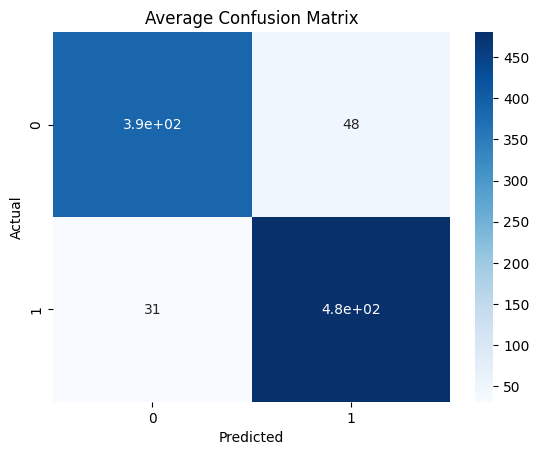

{'Average Accuracy': 0.9159439735137778,
 'Average Confusion Matrix': array([[386.6,  48.2],
        [ 31.4, 480.4]])}

In [15]:
cv_5(Sequential_CNN, train_images, train_labels_one_hot, epochs=5)

Epoch 1/5


2023-09-13 22:18:08.209129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 57s 373ms/step - loss: 0.1231 - accuracy: 0.9509 - val_loss: 0.1568 - val_accuracy: 0.9831
Epoch 2/5
30/30 [==============================] - 7s 248ms/step - loss: 0.0290 - accuracy: 0.9913 - val_loss: 0.0832 - val_accuracy: 0.9863
Epoch 3/5
30/30 [==============================] - 8s 251ms/step - loss: 0.0137 - accuracy: 0.9966 - val_loss: 0.0872 - val_accuracy: 0.9863
Epoch 4/5
30/30 [==============================] - 7s 239ms/step - loss: 0.0167 - accuracy: 0.9952 - val_loss: 0.0506 - val_accuracy: 0.9916
Epoch 5/5
30/30 [==============================] - 3s 29ms/step
Epoch 1/5
30/30 [==============================] - 7s 242ms/step - loss: 0.0354 - accuracy: 0.9900 - val_loss: 0.0117 - val_accuracy: 0.9968
Epoch 2/5
30/30 [==============================] - 7s 239ms/step - loss: 0.0160 - accuracy: 0.9955 - val_loss: 0.0122 - val_accuracy: 0.9979
Epoch 3/5
30/30 [==============================] - 7s 247ms/step - loss: 0.0094 - accuracy: 0.9968 

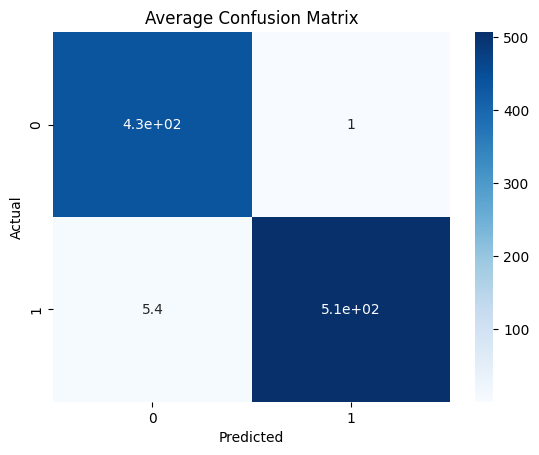

{'Average Accuracy': 0.9932413697645396,
 'Average Confusion Matrix': array([[433.8,   1. ],
        [  5.4, 506.4]])}

In [16]:
cv_5(Efficient_NetB0, train_images, train_labels_one_hot, epochs=5)

Epoch 1/5
30/30 [==============================] - 5s 43ms/step - loss: 9.2308 - accuracy: 0.5642 - val_loss: 0.8236 - val_accuracy: 0.4699
Epoch 2/5
30/30 [==============================] - 1s 22ms/step - loss: 0.6000 - accuracy: 0.6830 - val_loss: 0.5270 - val_accuracy: 0.7645
Epoch 3/5
30/30 [==============================] - 1s 21ms/step - loss: 0.5150 - accuracy: 0.7599 - val_loss: 0.4752 - val_accuracy: 0.7793
Epoch 4/5
30/30 [==============================] - 1s 21ms/step - loss: 0.4650 - accuracy: 0.7831 - val_loss: 0.4629 - val_accuracy: 0.7867
Epoch 5/5
30/30 [==============================] - 0s 6ms/step
Epoch 1/5
30/30 [==============================] - 1s 26ms/step - loss: 0.4636 - accuracy: 0.7834 - val_loss: 0.3962 - val_accuracy: 0.8321
Epoch 2/5
30/30 [==============================] - 1s 21ms/step - loss: 0.4163 - accuracy: 0.8275 - val_loss: 0.4012 - val_accuracy: 0.8321
Epoch 3/5
30/30 [==============================] - 1s 24ms/step - loss: 0.3540 - accuracy: 0.8526

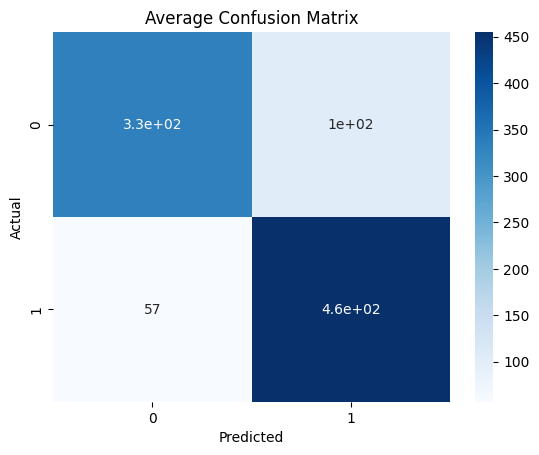

{'Average Accuracy': 0.832261665301129,
 'Average Confusion Matrix': array([[332.8, 102. ],
        [ 56.8, 455. ]])}

In [17]:
cv_5(AlexNet, train_images, train_labels_one_hot, epochs=5)